In [4]:
import torch
from transformers import BeitFeatureExtractor, BeitForImageClassification
from torch.utils.data import random_split, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from dataset import SingleImageDataset, FullLocationDataset
from geoguessr import HaversineLoss

In [2]:
feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-384')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-384').to("cuda")

model.classifier = torch.nn.Linear(768, 2).to("cuda")

c:\Users\erena\anaconda3\envs\Torch-DL\Lib\site-packages\transformers\models\beit\feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


In [3]:
checkpoint = torch.load("../models/model_epoch_8.pt")

checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_transformer_state_dict', 'optimizer_linear_state_dict', 'best_val_loss', 'train_losses', 'val_losses'])

In [4]:
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

for param in model.parameters():
    param.requires_grad = False

In [5]:
df = pd.read_csv("../data/annotations_unglued.csv")

df[['lat', 'lon']].describe()

,lat,lon
count,52800.000000,52800.000000
mean,45.651843,7.945692
std,4.650950,9.332917
min,36.066402,-9.464124
25%,41.999797,-0.306321
50%,45.770447,8.059136
75%,49.110363,16.272085
max,54.829307,24.115109


<Axes: ylabel='Density'>

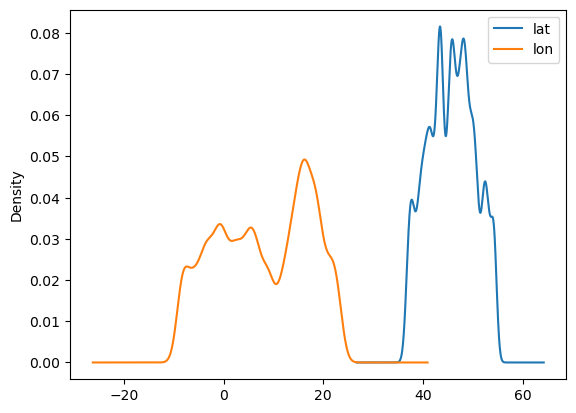

In [26]:
df[['lat', 'lon']].plot(kind="density")

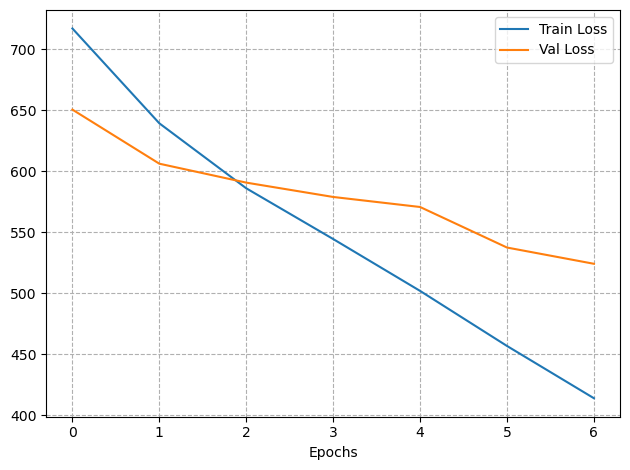

In [8]:
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

fig, ax = plt.subplots()

ax.plot(train_losses[1:], label="Train Loss")
ax.plot(val_losses[1:], label='Val Loss')

ax.set_xlabel("Epochs")

ax.grid(ls='--')
ax.legend()

fig.tight_layout()

In [18]:
torch.manual_seed(42)

dataset = SingleImageDataset()

train_set, _, test_set = random_split(dataset, [0.6, 0.2, 0.2])

train_loader = DataLoader(train_set, batch_size=128, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, num_workers=2, shuffle=False, pin_memory=True)

In [8]:
criterion = HaversineLoss()

In [21]:
n = 0
sum_lon = 0
sum_lat = 0
sum_sq_lon = 0
sum_sq_lat = 0

for _, labels in tqdm(train_loader):
    latitudes = labels[:, 0].detach()
    longtitudes = labels[:, 1].detach()

    n += latitudes.nelement()
    sum_lon += longtitudes.sum().item()
    sum_lat += latitudes.sum().item()
    sum_sq_lon += torch.pow(longtitudes, 2).sum().item()
    sum_sq_lat += torch.pow(latitudes, 2).sum().item()

  0%|          | 0/248 [00:00<?, ?it/s]

In [22]:
mean_lon = sum_lon / n
mean_lat = sum_lat / n

var_lon = (sum_sq_lon - sum_lon**2 / n) / (n - 1)
var_lat = (sum_sq_lat - sum_lat**2 / n) / (n - 1)

mean_lon, mean_lat, var_lon, var_lat

(7.951020843814118, 45.654047571047386, 86.98158021195114, 21.573097655562876)

In [23]:
var_lon**0.5, var_lat**0.5

(9.326391596536741, 4.6446848822673505)

In [9]:
test_loss_batches = []

for images, labels in tqdm(test_loader):
    with torch.no_grad():
        model.eval()
        labels = labels.cuda(non_blocking=True)

        features = feature_extractor(images, return_tensors="pt")
        features = features['pixel_values'].cuda(non_blocking=True)

        y_pred = model(features)

        loss = criterion(y_pred.logits, labels)
        test_loss_batches.append(loss.item())

  0%|          | 0/330 [00:00<?, ?it/s]

In [18]:
mean_loss = np.mean(test_loss_batches)

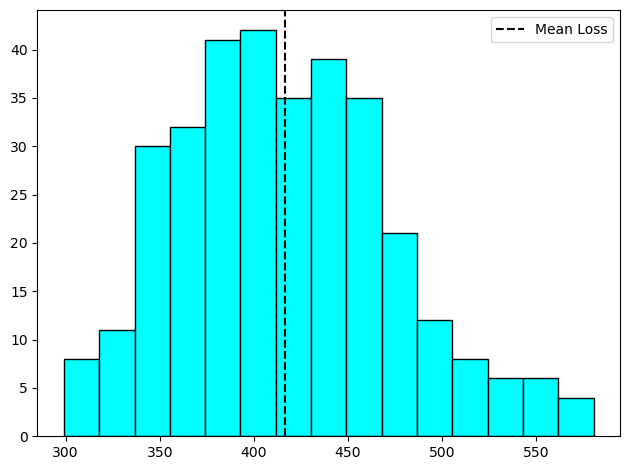

In [21]:
fig, ax = plt.subplots()

ax.hist(test_loss_batches, edgecolor='black', bins=15, color='cyan')

ax.axvline(mean_loss, ls='--', color='black', label='Mean Loss')

ax.legend()

fig.tight_layout()